In [5]:
# Header for the notebook
from datetime import datetime
from IPython.display import display, Markdown

# Get the current date
title = "Coding Project Notebook - Circular Task"
current_date = datetime.now().strftime("%d %B %Y, %H:%M:%S")
authors = "Victor Salvat and Jin Wei Zhang (and Copilot)"

# Insert the date into the notebook
display(Markdown(f"# {title}"))
display(Markdown(f"{current_date}"))
display(Markdown(f"by {authors}"))

# Coding Project Notebook - Circular Task

22 November 2025, 15:04:50

by Victor Salvat and Jin Wei Zhang (and Copilot)

Introduction



## Table of Contents
<a id="total-title"></a>
- [1. Reproduce the graphics](#1-title)
- [2. Recompute the values](#2-title)
- [3. Test our own generated data](#3-title)
- [4. Discussion & Conclusion](#4-title)

---
<a id="1-title"></a>
# 1. [Reproduce the graphics](#total-title)

In [1]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

# install widget mode
%matplotlib widget

Found indices of original X≈0 split points: [ 3972  7871 11770 15655 19592]
Number of split points: 5 (should be 5)

Group 1 data: Indices [1, 3971], Data length: 3971

Group 2 data: Indices [3973, 7870], Data length: 3898

Group 3 data: Indices [7872, 11769], Data length: 3898

Group 4 data: Indices [11771, 15654], Data length: 3884

Group 5 data: Indices [15656, 19591], Data length: 3936

Successfully split into 5 valid data groups


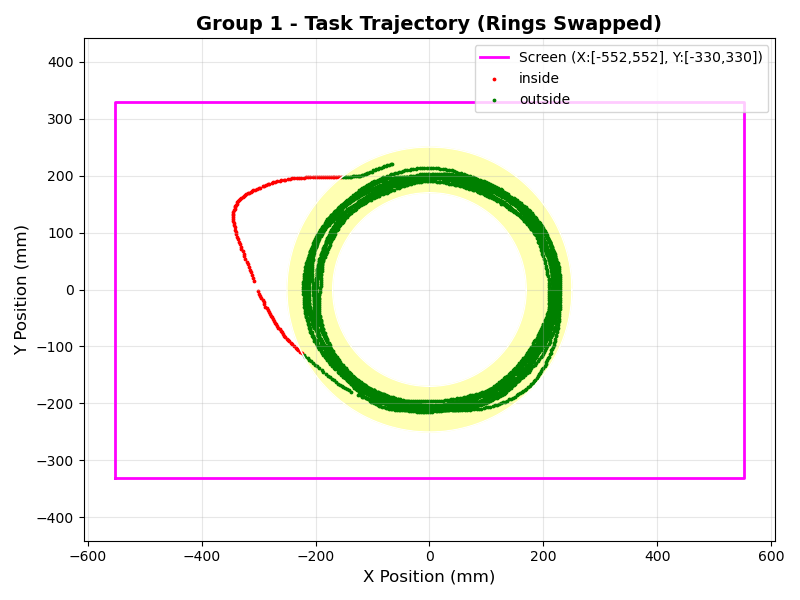

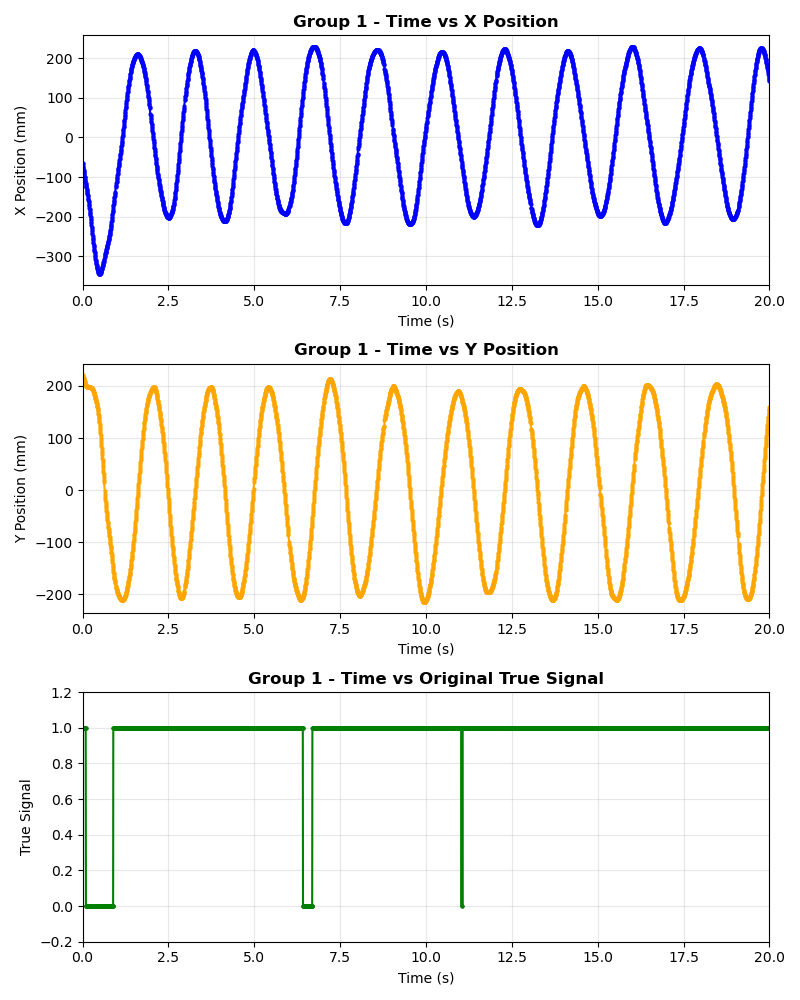

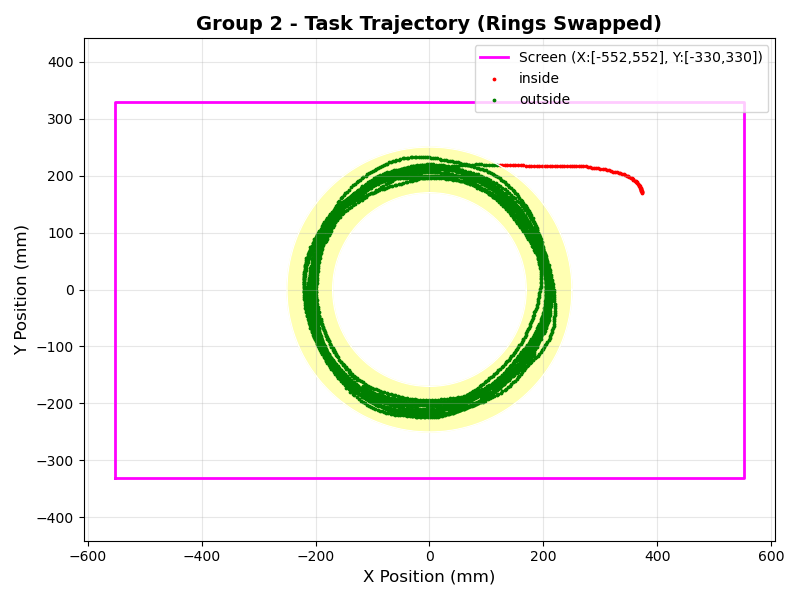

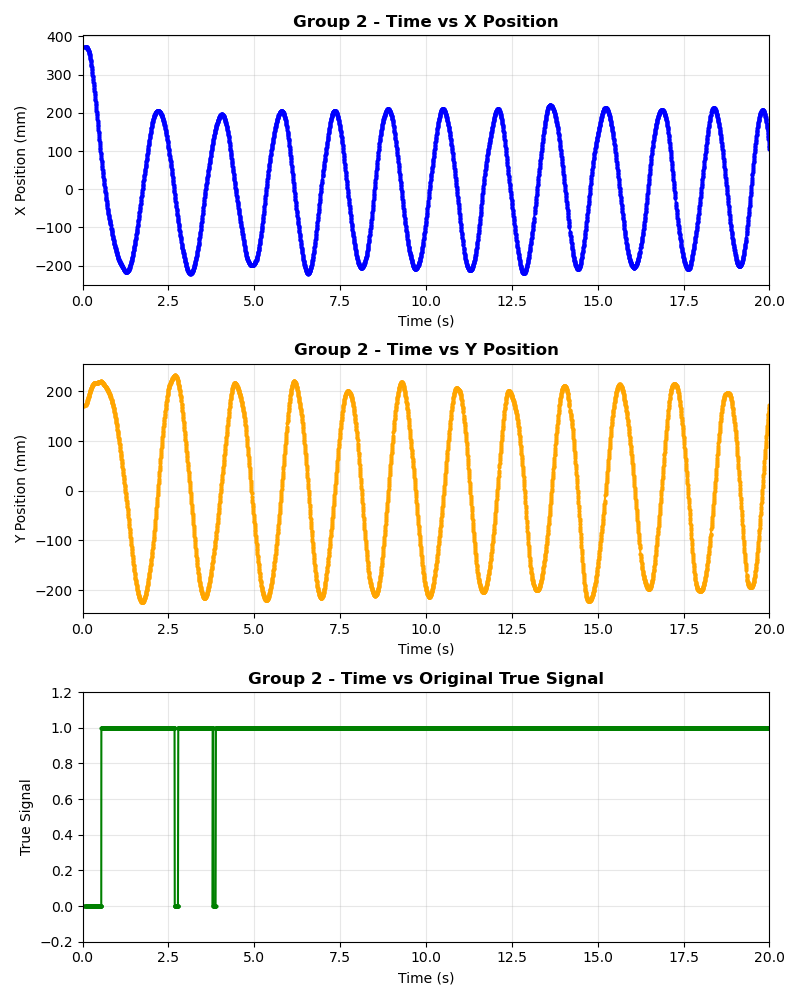

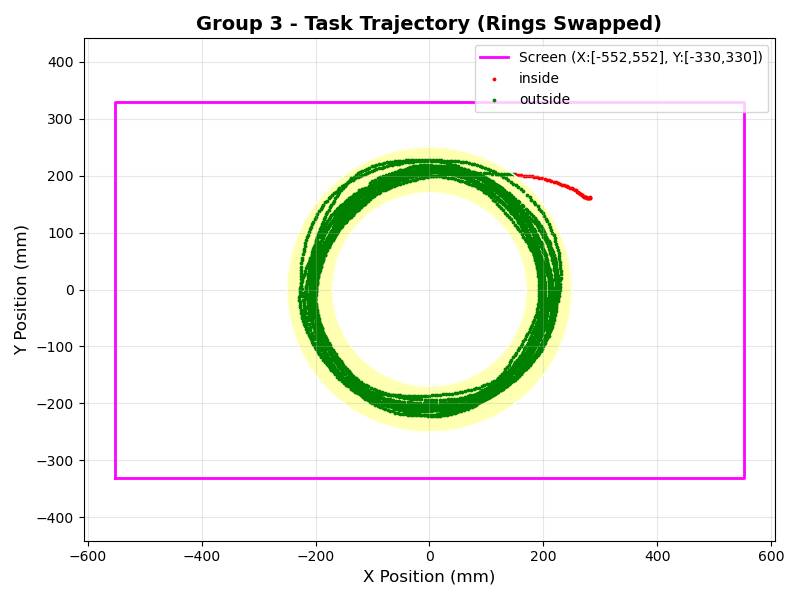

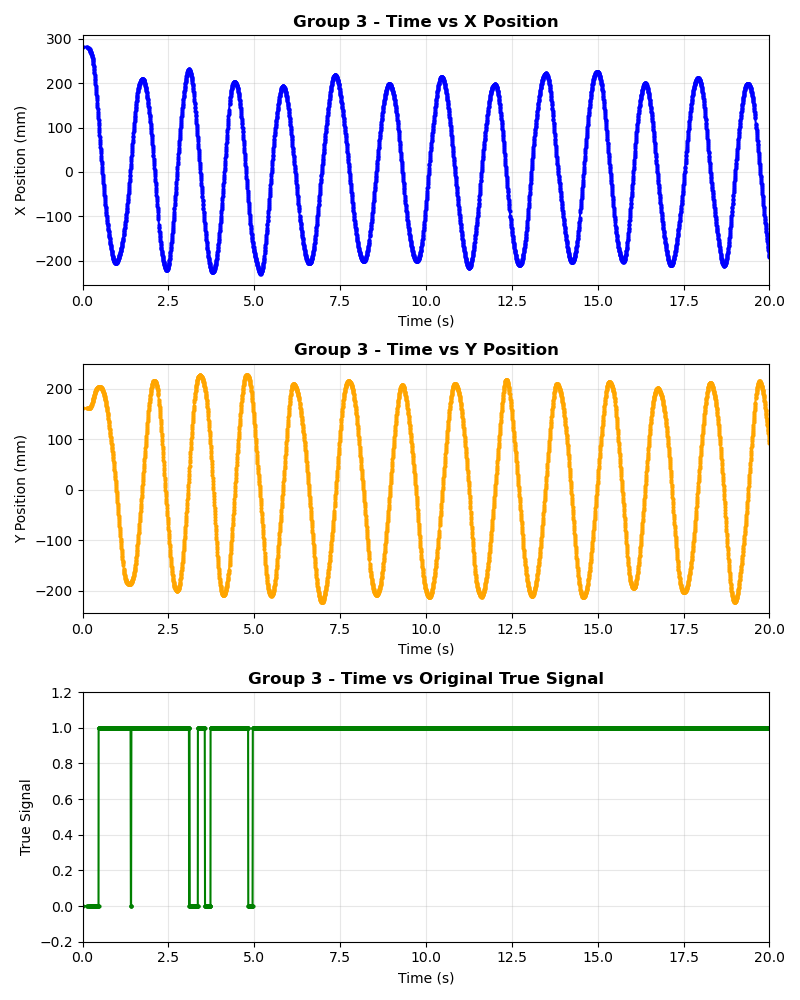

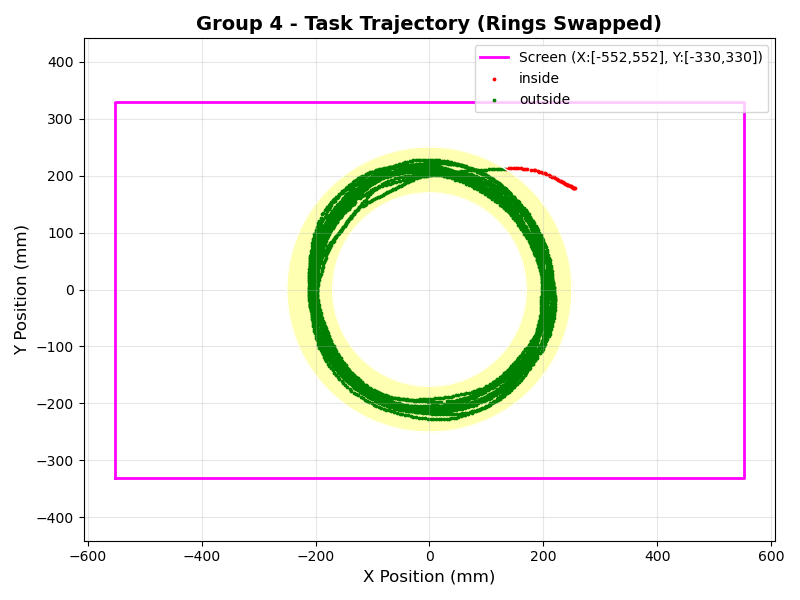

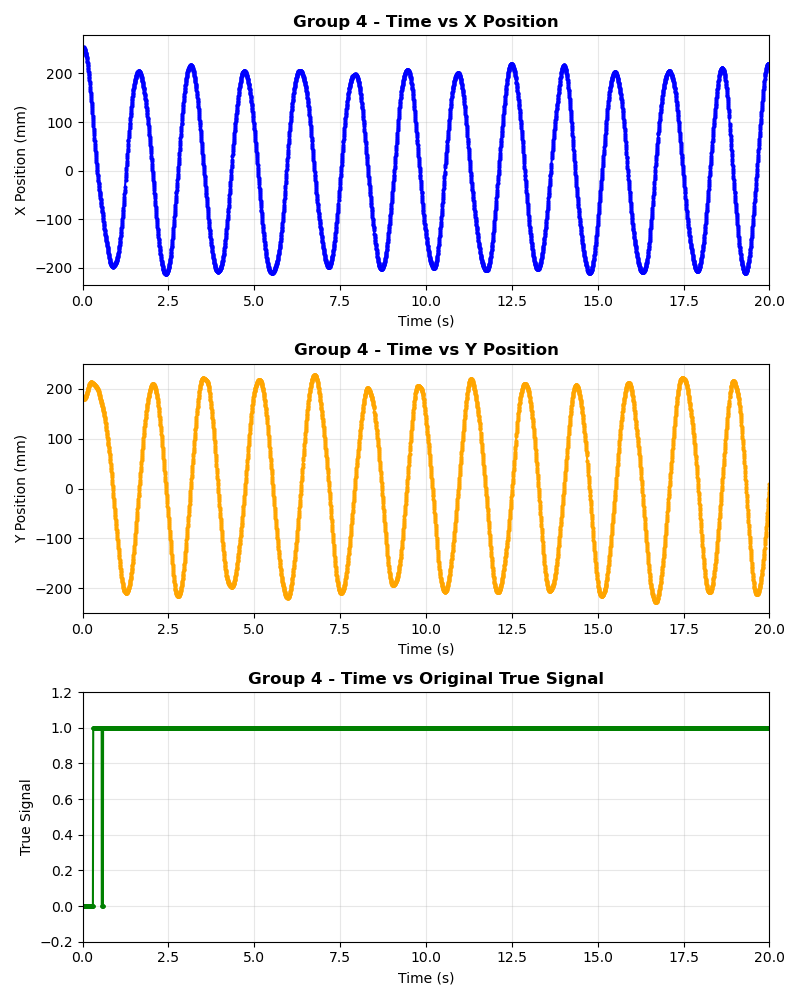

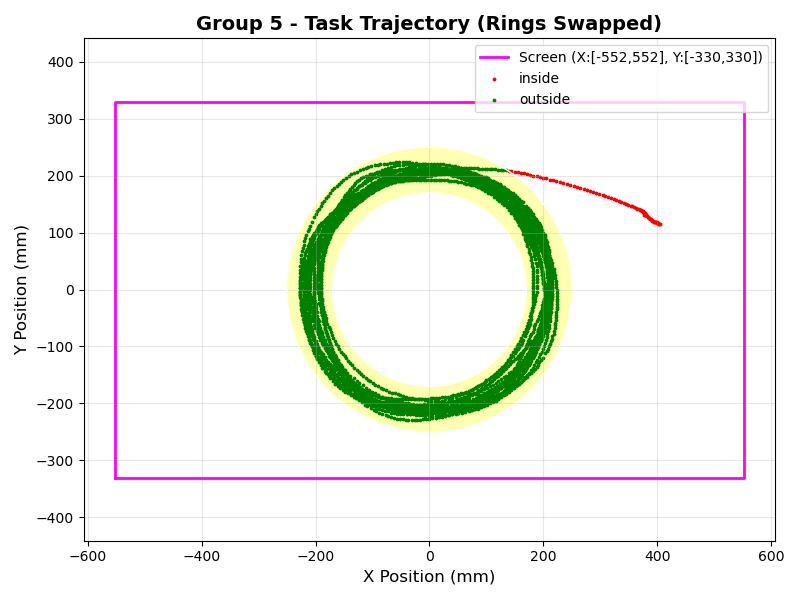

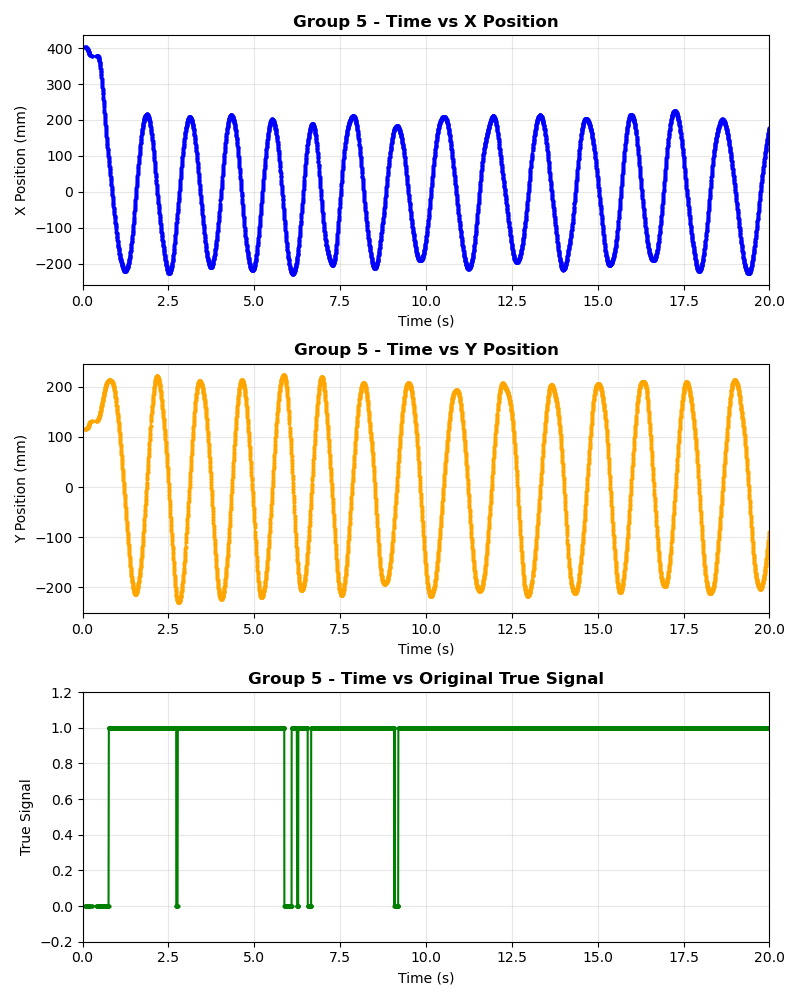

In [3]:
# Read CSV data
file_name = 'data\\001MoDe_R1.csv'
data = np.genfromtxt(file_name, delimiter=',', skip_header=4)

time_1 = data[:, 0]
x_position = data[:, 1] - 552  # X-axis: [-552,552] (origin aligned with target center)
y_position = data[:, 2] - 330  # Y-axis: [-330,330] (origin aligned with target center)
# True_signal is not used; position is determined by distance

# ----------------------
# Core: 5 original X=0 points → strictly split into 5 data groups (independent time per group)
# ----------------------
raw_x = data[:, 1]  # Original X-coordinate (without subtracting 552)
zero_x_indices = np.where(np.abs(raw_x) < 0.5)[0]
print(f"Found indices of original X≈0 split points: {zero_x_indices}")
print(f"Number of split points: {len(zero_x_indices)} (should be 5)")

if len(zero_x_indices) != 5:
    raise ValueError(f"Expected 5 original X=0 split points, but found {len(zero_x_indices)}. Please check the data!")

# Loop to split into 5 data groups (strictly according to requirements)
data_groups = []
for i in range(5):
    if i == 0:
        # Group 1: Index 1 → before first split point (excludes split point)
        start_idx = 1
        end_idx = zero_x_indices[0] - 1
    else:
        # Groups 2-5: After previous split point → before current split point (excludes both split points)
        start_idx = zero_x_indices[i-1] + 1
        end_idx = zero_x_indices[i] - 1
    
    # Ensure valid indices (start_idx < end_idx)
    if start_idx >= end_idx:
        print(f"Warning: Invalid indices for Group {i+1} ([{start_idx}, {end_idx}]), skipping this group!")
        continue
    
    # Extract all data for current group (X/Y/time/True Signal, only valid for current group)
    group = {
        'group_num': i+1,
        'start_idx': start_idx,
        'end_idx': end_idx,
        'x': x_position[start_idx:end_idx+1],  # Slice is right-exclusive, need +1
        'y': y_position[start_idx:end_idx+1],
        'time': time_1[start_idx:end_idx+1],   # Independent time per group, only current group range
        'true_signal': data[:, 3][start_idx:end_idx+1]
    }
    data_groups.append(group)
    print(f"\nGroup {i+1} data: Indices [{start_idx}, {end_idx}], Data length: {len(group['x'])}")

print(f"\nSuccessfully split into {len(data_groups)} valid data groups")

# ----------------------
# Loop to plot each group (2 plots per group: separate trajectory plot + 3 independent time subplots)
# ----------------------
externalRadius = 250.0
internalRadius = 170.0
screen_x = [-552, 552, 552, -552, -552]
screen_y = [-330, -330, 330, 330, -330]
theta = np.linspace(0, 2*np.pi, 1000)
outer_circle_x = externalRadius * np.cos(theta)
outer_circle_y = externalRadius * np.sin(theta)
inner_circle_x = internalRadius * np.cos(theta)
inner_circle_y = internalRadius * np.sin(theta)

for group in data_groups:
    group_num = group['group_num']
    x = group['x']
    y = group['y']
    time = group['time']  # Time only for current group, changes with each loop
    true_signal = group['true_signal']
    
    # ----------------------
    # Plot 1: Separate trajectory plot for the group (original logic unchanged)
    # ----------------------
    plt.figure(figsize=(8, 6))
    
    # 1. Bottom layer: Screen
    plt.plot(screen_x, screen_y, color='magenta', linewidth=2, label='Screen (X:[-552,552], Y:[-330,330])')
    
    # 2. Middle layer: Yellow annular background
    ring = Wedge(
        center=(0, 0),
        r=externalRadius,
        theta1=0, theta2=360,
        width=externalRadius - internalRadius,
        color='yellow',
        alpha=0.3
    )
    plt.gca().add_patch(ring)
    
    # 3. Top layer: Target borders
    plt.plot(outer_circle_x, outer_circle_y, color='white', linewidth=1.0)
    plt.plot(inner_circle_x, inner_circle_y, color='white', linewidth=1.0)
    
    # 4. Color-coded trajectory (ring-swapped logic)
    distances = np.sqrt(x**2 + y**2)
    x_red = x[(distances >= internalRadius) & (distances <= externalRadius)]  # Outside → red
    y_red = y[(distances >= internalRadius) & (distances <= externalRadius)]
    x_green = x[(distances < internalRadius) | (distances > externalRadius)]  # Inside → green
    y_green = y[(distances < internalRadius) | (distances > externalRadius)]
    
    plt.scatter(x_green, y_green, s=3, color='red', label='inside')
    plt.scatter(x_red, y_red, s=3, color='green', label='outside')
    
    # Style adjustments
    plt.title(f'Group {group_num} - Task Trajectory (Rings Swapped)', fontweight='bold', fontsize=14)
    plt.xlabel('X Position (mm)', fontsize=12)
    plt.ylabel('Y Position (mm)', fontsize=12)
    plt.xlim([-552, 552])
    plt.ylim([-330, 330])
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right', fontsize=10)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    # ----------------------
    # Plot 2: 3 time series subplots for the group (time only for current group, normalized to 0~20s)
    # ----------------------
    fig, axs = plt.subplots(3, 1, figsize=(8, 10))
    
    # Normalize time to 0~20 seconds (only using current group's time, recalculated each loop)
    time_min = time.min()
    time_max = time.max()
    if time_max - time_min < 1e-6:
        time_mapped = np.zeros_like(time)
    else:
        time_mapped = (time - time_min) / (time_max - time_min) * 20
    
    # Subplot 1: Time vs X Position (current group time)
    axs[0].plot(time_mapped, x, color='blue', marker='o', markersize=2)
    axs[0].set_title(f'Group {group_num} - Time vs X Position', fontweight='bold')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('X Position (mm)')
    axs[0].grid(True, alpha=0.3)
    axs[0].set_xlim([0, 20])
    
    # Subplot 2: Time vs Y Position (current group time)
    axs[1].plot(time_mapped, y, color='orange', marker='o', markersize=2)
    axs[1].set_title(f'Group {group_num} - Time vs Y Position', fontweight='bold')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Y Position (mm)')
    axs[1].grid(True, alpha=0.3)
    axs[1].set_xlim([0, 20])
    
    # Subplot 3: Time vs Original True Signal (current group time)
    axs[2].plot(time_mapped, true_signal, color='green', marker='o', markersize=2)
    axs[2].set_title(f'Group {group_num} - Time vs Original True Signal', fontweight='bold')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('True Signal')
    axs[2].grid(True, alpha=0.3)
    axs[2].set_ylim([-0.2, 1.2])
    axs[2].set_xlim([0, 20])
    
    plt.tight_layout()
    plt.show()

<a id="2-title"></a>
# 2. [Recompute the values](#total-title)




<a id="3-title"></a>
# 3. [Test our own generated data](#total-title)


<a id="4-title"></a>
# 4. [Discussion & Conclusion](#total-title)

In [7]:
# Title 1
# Add your content for Title 1 here.

In [8]:
# https://nbconvert.readthedocs.io/en/latest/removing_cells.html

# https://github.com/msm1089/ipynbname/issues/17#issuecomment-1293269863


from traitlets.config import Config
from nbconvert.exporters import HTMLExporter
from nbconvert.preprocessors import TagRemovePreprocessor
from IPython import get_ipython


def get_notebook_name():
    """
    Get the current notebook name (without extension).
    """
    ip = get_ipython()
    path = None
    if "__vsc_ipynb_file__" in ip.user_ns:
        path = ip.user_ns["__vsc_ipynb_file__"]

    return path.split("/")[-1].split(".")[0]


# Get the notebook name
notebook_file_name = get_notebook_name()


# Setup config
c = Config()

# Configure tag removal - be sure to tag your cells to remove  using the
# words remove_cell to remove cells. You can also modify the code to use
# a different tag word
c.TagRemovePreprocessor.remove_cell_tags = ("remove",)
c.TagRemovePreprocessor.remove_all_outputs_tags = ("remove_output",)
c.TagRemovePreprocessor.remove_input_tags = ("hide",)
c.TagRemovePreprocessor.enabled = True
c.HTMLExporter.preprocessors = ["nbconvert.preprocessors.TagRemovePreprocessor"]

# ensure the graphics are included in the html
c.HTMLExporter.embed_images = True
# do not show the input code cells (distracts from the output)
c.HTMLExporter.exclude_output_prompt = True
c.HTMLExporter.exclude_input_prompt = True

# Configure the exporter
exporter = HTMLExporter(config=c)
exporter.register_preprocessor(TagRemovePreprocessor(config=c), True)


# run our exporter - returns a tuple - first element with html,
# second with notebook metadata
output = HTMLExporter(config=c).from_filename(notebook_file_name + ".ipynb")

# Write to output html file
with open(notebook_file_name + ".html", "w") as f:
    f.write(output[0])

# open the file with the operating system
import os

# if osx use open, if linux use xdg-open, if windows use start
try:
    if os.name == "posix":
        if os.uname().sysname == "Darwin":
            # macOS
            errorCode = os.system("open " + notebook_file_name + ".html")
        else:
            # Linux
            errorCode = os.system("xdg-open " + notebook_file_name + ".html")
    elif os.name == "nt":
        # Windows
        errorCode = os.system("start " + notebook_file_name + ".html")
    else:
        print("Unsupported OS")
except Exception as e:
    print("Error opening file: ", e)